In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [2]:
# -----------------------------
# 1. Download the stock data
# -----------------------------
ticker = 'RELIANCE.BO'
start_date = '2022-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

data = yf.download(ticker, start=start_date, end=end_date)
data.dropna(inplace=True)

# Reset index so "Date" becomes a column
data.reset_index(inplace=True)

# For convenience, rename columns to standard naming
data.rename(columns={
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)

data.sort_values('date', inplace=True)
data.reset_index(drop=True, inplace=True)


[*********************100%***********************]  1 of 1 completed


In [3]:
# -----------------------------
# 2. Feature Engineering
# -----------------------------
def compute_rsi(series, window=14):
    """Compute the RSI for a stock price series."""
    delta = series.diff()
    gain = (delta.mask(delta < 0, 0)).rolling(window=window).mean()
    loss = (-delta.mask(delta > 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['rsi'] = compute_rsi(data['close'], 14)

# SMA
data['sma_20'] = data['close'].rolling(window=20).mean()

# Support (rolling min)
data['support'] = data['close'].rolling(window=20).min()

# Resistance (rolling max)
data['resistance'] = data['close'].rolling(window=20).max()

# Drop initial NaNs from rolling calculations
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)


In [4]:
lookback = 30  # Number of past days we use as features

feature_cols = ['open', 'high', 'low', 'close', 'volume', 'rsi', 'sma_20', 'support', 'resistance']
# We'll predict 'close' for the next day.

# 1) Scale features for stable neural network training
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[feature_cols])

# 2) Build sequences (X) and labels (y)
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, :])  # 30 rows of features
    y.append(scaled_data[i, feature_cols.index('close')])  # next day's close (scaled)

X = np.array(X)
y = np.array(y)

# For reference, keep track of the real close values (unscaled) for MSE comparison
actual_close = data['close'].values[lookback:]  # aligns with X,y indexing


In [5]:
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
actual_close_test = actual_close[train_size:]


In [6]:
# -----------------------------
# 5. Build LSTM model
# -----------------------------
model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(64))
model.add(Dropout(0.2))

model.add(Dense(1))  # single output: next day's close

model.compile(optimizer='adam', loss='mean_squared_error')

# -----------------------------
# 6. Train
# -----------------------------
epochs = 30
batch_size = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)


C:\Users\Aneesh Antony\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1228 - val_loss: 0.0398
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0137 - val_loss: 0.0105
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0104 - val_loss: 0.0084
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0074 - val_loss: 0.0063
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 10/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 11/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0

In [7]:
# -----------------------------
# 7. Evaluate the model
# -----------------------------
y_pred_scaled = model.predict(X_test)
# y_pred_scaled is shape (#samples, 1)

# We only want to invert the 'close' feature, but we scaled them all together.
# Create a placeholder to invert transform properly
# We'll fill everything except the close column with zero, then place y_pred_scaled in the close column
pred_features_placeholder = np.zeros((len(y_pred_scaled), len(feature_cols)))
pred_features_placeholder[:, feature_cols.index('close')] = y_pred_scaled[:, 0]

# Invert transform
pred_inverted = scaler.inverse_transform(pred_features_placeholder)
pred_close = pred_inverted[:, feature_cols.index('close')]

# Evaluate
mse = mean_squared_error(actual_close_test, pred_close)
rmse = sqrt(mse)
r2 = r2_score(actual_close_test, pred_close)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2 : {r2:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Test MSE: 668.7847
Test RMSE: 25.8609
Test R2 : 0.9518


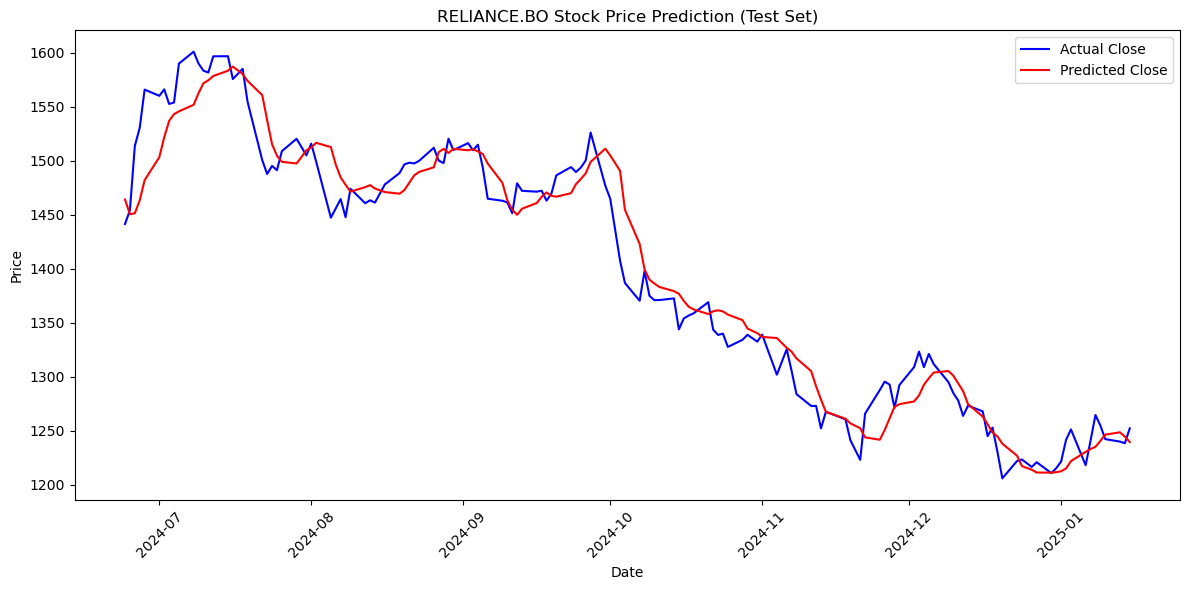

In [8]:
plt.figure(figsize=(12,6))
plt.plot(data['date'][lookback+train_size:], actual_close_test, label='Actual Close', color='blue')
plt.plot(data['date'][lookback+train_size:], pred_close, label='Predicted Close', color='red')
plt.title(f"{ticker} Stock Price Prediction (Test Set)")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# We'll make a naive "future" set by reusing the last 'lookback' days of known data 
# and shift forward, ignoring the fact that real RSI, SMA, etc. wouldn't be known.

# last 'lookback' rows from scaled_data
last_sequence = scaled_data[-lookback:, :].copy()

# We'll predict 7 days ahead
future_days = 7

future_predictions = []

current_sequence = last_sequence  # shape (lookback, #features)
for day in range(future_days):
    pred_scaled = model.predict(current_sequence[np.newaxis, :, :])  # shape (1, 1)
    
    # Insert into placeholder to invert scale
    placeholder = np.zeros((1, len(feature_cols)))
    placeholder[0, feature_cols.index('close')] = pred_scaled[0, 0]
    pred_inverted = scaler.inverse_transform(placeholder)
    next_close = pred_inverted[0, feature_cols.index('close')]
    
    future_predictions.append(next_close)
    
    # Now we'd shift the sequence to add the new predicted close. 
    # But we also would need the new open/high/low/volume/RSI, etc. 
    # For a real forecast, you must estimate or forecast those as well.
    # For demonstration, let's just keep them the same
    new_scaled_row = current_sequence[-1, :].copy()
    new_scaled_row[feature_cols.index('close')] = pred_scaled[0, 0]
    
    # shift left and append the new row
    current_sequence = np.concatenate((current_sequence[1:], new_scaled_row[np.newaxis,:]), axis=0)

print("Future 7-day predictions (naive approach):")
for i, val in enumerate(future_predictions, 1):
    print(f"Day {i}: {val:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Future 7-day predictions (naive approach):
Day 1: 1238.49
Day 2: 1237.71
Day 3: 1237.06
Day 4: 1236.49
Day 5: 1236.04
Day 6: 1235.75
Day 7: 1235.66


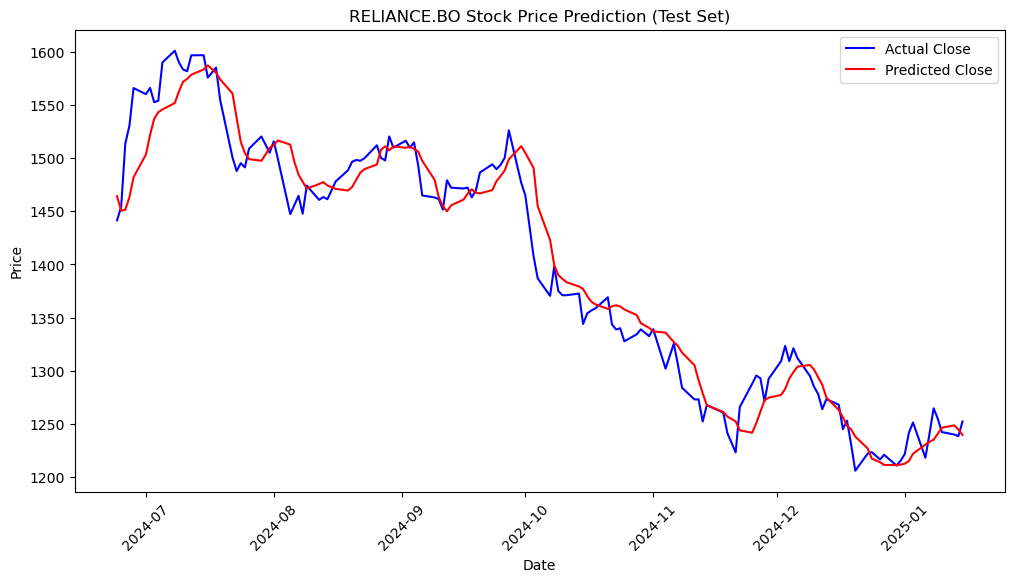

In [10]:
# ----------------------------------------------------
# 1) Plot the Actual vs. Predicted lines
#    (This is your existing code snippet)
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
test_dates = data['date'][lookback + train_size:]  # the x-axis for your test set
plt.plot(test_dates, actual_close_test, label='Actual Close', color='blue')
plt.plot(test_dates, pred_close, label='Predicted Close', color='red')

plt.title(f"{ticker} Stock Price Prediction (Test Set)")
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()


In [11]:
# ----------------------------------------------------
# 2) Define Buy/Hold/Sell signals
#    We'll use a simple % threshold; e.g., 2%
# ----------------------------------------------------
threshold = 0.02  # e.g., 2%
signals = []
for actual_price, predicted_price in zip(actual_close_test, pred_close):
    if predicted_price > actual_price * (1 + threshold):
        signals.append('BUY')
    elif predicted_price < actual_price * (1 - threshold):
        signals.append('SELL')
    else:
        signals.append('HOLD')

In [14]:
# Suppose you prepared these arrays so their length matches actual_close_test & pred_close
rsi_test = data['rsi'].iloc[train_size+lookback:].values
sma_test = data['sma_20'].iloc[train_size+lookback:].values
support_test   = data['support'].iloc[train_size + lookback:].values
resistance_test = data['resistance'].iloc[train_size + lookback:].values

threshold = 0.005
signals = []

for i, (actual_price, predicted_price) in enumerate(zip(actual_close_test, pred_close)):
    rsi_val = rsi_test[i]
    current_sma = sma_test[i]
    support = support_test[i]
    resistance = resistance_test[i]

    # For example, price_above_sma = True if actual > current SMA
    price_above_sma = (actual_price > current_sma)
    
    if (predicted_price > actual_price * (1 + threshold))  or price_above_sma and actual_price<support or (rsi_val < 30):
        signals.append('BUY')
    elif (predicted_price < actual_price * (1 - threshold)) or price_above_sma==False and actual_price>resistance or (rsi_val > 70) :
        signals.append('SELL')
    else:
        signals.append('HOLD')



In [15]:
# 1) Flatten (if necessary)
test_dates_1d = np.array(test_dates).ravel()  # ensure it's shape (N,)
actual_close_test_1d = np.array(actual_close_test).ravel()
pred_close_1d = np.array(pred_close).ravel()
signals_1d = np.array(signals).ravel()  # or just use signals if it’s already a list of strings

# 2) Double-check lengths match
print("Length of test_dates:", len(test_dates_1d))
print("Length of actual_close_test:", len(actual_close_test_1d))
print("Length of pred_close:", len(pred_close_1d))
print("Length of signals:", len(signals_1d))

# 3) Create the DataFrame
signal_df = pd.DataFrame({
    'date': test_dates_1d,
    'actual_price': actual_close_test_1d,
    'predicted_price': pred_close_1d,
    'signal': signals_1d
})

print(signal_df.head(50))


Length of test_dates: 140
Length of actual_close_test: 140
Length of pred_close: 140
Length of signals: 140
         date  actual_price  predicted_price signal
0  2024-06-24   1441.500000      1464.163648    BUY
1  2024-06-25   1454.250000      1450.531363   HOLD
2  2024-06-26   1513.699951      1451.444336   SELL
3  2024-06-27   1530.550049      1463.362101   SELL
4  2024-06-28   1565.925049      1482.052670   SELL
5  2024-07-01   1560.175049      1503.422197   SELL
6  2024-07-02   1566.150024      1521.798671   SELL
7  2024-07-03   1552.650024      1536.978829   SELL
8  2024-07-04   1553.949951      1543.214415   SELL
9  2024-07-05   1590.025024      1545.786509   SELL
10 2024-07-08   1601.050049      1551.846561   SELL
11 2024-07-09   1590.074951      1562.634492   SELL
12 2024-07-10   1583.449951      1571.824041   SELL
13 2024-07-11   1581.750000      1574.548888   SELL
14 2024-07-12   1596.724976      1578.507393   SELL
15 2024-07-15   1596.849976      1583.398312   SELL
16 2024-

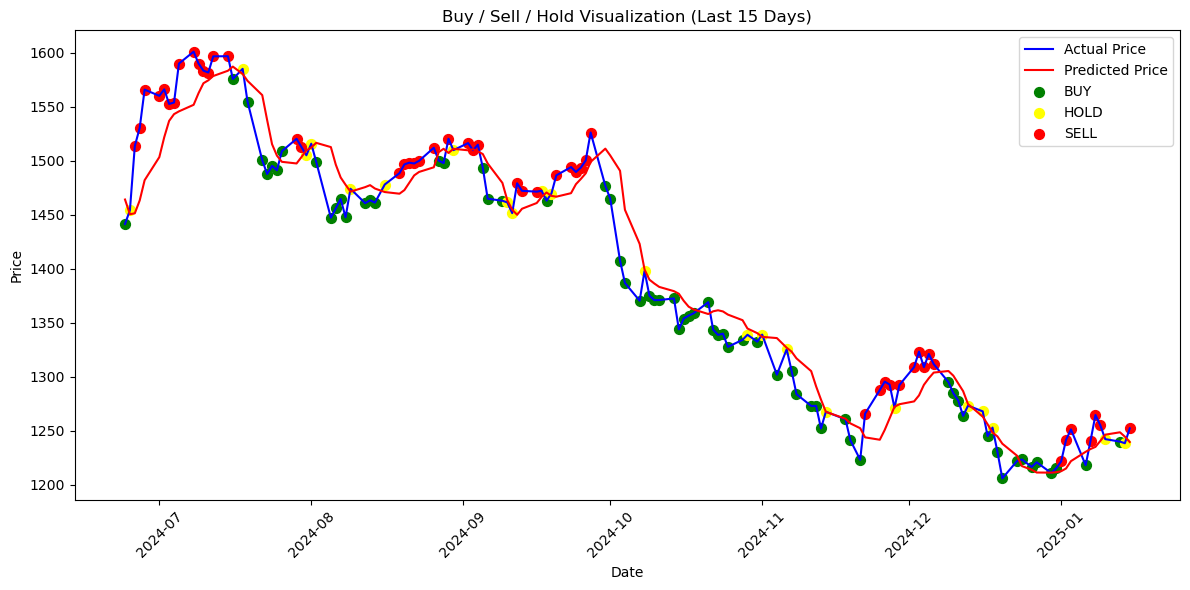

In [17]:
# --------------------------------------
# 1) Slice the last 15 days of data
# --------------------------------------
last_n_days = 150
sub_df = signal_df.tail(last_n_days)  # Only the final 15 days

# --------------------------------------
# 2) Plot Actual and Predicted Prices for those 15 days
# --------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(sub_df['date'], sub_df['actual_price'], label='Actual Price', color='blue')
plt.plot(sub_df['date'], sub_df['predicted_price'], label='Predicted Price', color='red')

# --------------------------------------
# 3) Overlay signals as scatter points
# --------------------------------------
signal_colors = {
    'BUY': 'green',
    'SELL': 'red',
    'HOLD': 'yellow'
}

for sig_label, group_df in sub_df.groupby('signal'):
    plt.scatter(
        group_df['date'],
        group_df['actual_price'],
        color=signal_colors[sig_label],
        label=sig_label,
        s=50
    )

# --------------------------------------
# 4) Deduplicate legend entries
# --------------------------------------
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Buy / Sell / Hold Visualization (Last 15 Days)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
